In [2]:
!pip install netcdf4

     |████████████████████████████████| 4.7MB 6.9MB/s 
     |████████████████████████████████| 296kB 41.2MB/s 


In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from skimage.transform import pyramid_expand

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive")

Mounted at /content/drive


In [5]:
input_path = '/content/drive/My Drive/aivcc_cornvolution/data'

In [6]:
print(input_path)
for dirname, _, filenames in os.walk(input_path):
    print(dirname)

/content/drive/My Drive/aivcc_cornvolution/data
/content/drive/My Drive/aivcc_cornvolution/data
/content/drive/My Drive/aivcc_cornvolution/data/gdhy_v1.2_v1.3_20190128
/content/drive/My Drive/aivcc_cornvolution/data/gdhy_v1.2_v1.3_20190128/maize
/content/drive/My Drive/aivcc_cornvolution/data/gdhy_v1.2_v1.3_20190128/maize_major
/content/drive/My Drive/aivcc_cornvolution/data/gdhy_v1.2_v1.3_20190128/maize_second
/content/drive/My Drive/aivcc_cornvolution/data/gdhy_v1.2_v1.3_20190128/rice
/content/drive/My Drive/aivcc_cornvolution/data/gdhy_v1.2_v1.3_20190128/rice_major
/content/drive/My Drive/aivcc_cornvolution/data/gdhy_v1.2_v1.3_20190128/rice_second
/content/drive/My Drive/aivcc_cornvolution/data/gdhy_v1.2_v1.3_20190128/soybean
/content/drive/My Drive/aivcc_cornvolution/data/gdhy_v1.2_v1.3_20190128/wheat
/content/drive/My Drive/aivcc_cornvolution/data/gdhy_v1.2_v1.3_20190128/wheat_spring
/content/drive/My Drive/aivcc_cornvolution/data/gdhy_v1.2_v1.3_20190128/wheat_winter
/content/driv

In [7]:
gdhy_path = os.path.join(input_path, 'gdhy_v1.2_v1.3_20190128')
crops_path = os.path.join(input_path, 'Production_Crops_E_All_Data')
indices_path = os.path.join(input_path, 'Production_Indices_E_All_Data')
lsprimary_path = os.path.join(input_path, 'Production_LivestockPrimary_E_All_Data')
lsprocessed_path = os.path.join(input_path, 'Production_LivestockProcessed_E_All_Data')
climateuos_path = os.path.join(input_path, 'climate_uos')

# Specific agricultural data

In [8]:
##### crops  ####

#crop data no flag
crops_df = pd.read_csv(os.path.join(crops_path, 'Production_Crops_E_All_Data_NOFLAG.csv'), encoding='ISO-8859-1')
#flags
crops_flags_df = pd.read_csv(os.path.join(crops_path, 'Production_Crops_E_Flags.csv'), encoding='ISO-8859-1')
#crop data flags
crops_flagged_df = pd.read_csv(os.path.join(crops_path, 'Production_Crops_E_All_Data.csv'), encoding='ISO-8859-1')

#### end crop data ####

#### production indices ####

indices_df = pd.read_csv(os.path.join(indices_path, 'Production_Indices_E_All_Data_NOFLAG.csv'), encoding='ISO-8859-1')

#### end production indices

#### livestock #####
lsprimary_df = pd.read_csv(os.path.join(lsprimary_path, 'Production_LivestockPrimary_E_All_Data_NOFLAG.csv'), encoding='ISO-8859-1')
lsprocessed_df = pd.read_csv(os.path.join(lsprocessed_path, 'Production_LivestockProcessed_E_All_Data_NOFLAG.csv'), encoding='ISO-8859-1')

#### end livestock ####

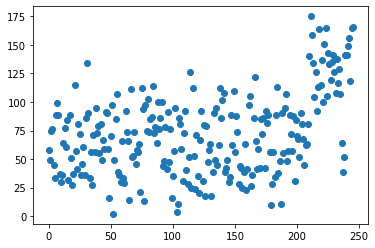

In [9]:
# how many items per area?
num_group_items = np.array([group.size for group in crops_df.groupby(by='Area Code')['Item Code'].unique()])
plt.figure()
plt.scatter(range(num_group_items.size), num_group_items)
plt.show()

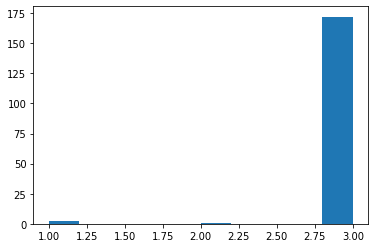

In [10]:
# how many elements per item?
num_item_elements = np.array([group.size for group in crops_df.groupby(by='Item Code')['Element Code'].unique()])
plt.figure()
plt.hist(num_item_elements)
plt.show()

# some data is missing!

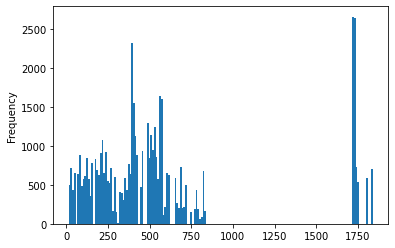

In [11]:
# histogram over the individual item codes
item_codes = crops_df['Item Code']
plt.figure()
item_codes.plot.hist(bins=crops_df['Item Code'].unique().size)
plt.show()

## Intermediate notes

- 3 items per element: area harvested, yield, production
- what to do with the NaN entires? 
    - estimate with mixed gaussians or so?
    - set to mean value?
- feed yield to network!

$\text{yield} = \frac{\text{production}}{\text{area harvested}}$ 

In [12]:
# map names to ids
crops_areas = crops_df['Area'].unique()
crops_area_codes = crops_df['Area Code'].unique()
crops_areas_map = {}
for area, code in zip(crops_areas, crops_area_codes):
    crops_areas_map[code] = area

crops_items = crops_df['Item'].unique()
crops_item_codes = crops_df['Item Code'].unique()
crops_item_map = {}
for item, code in zip(crops_items, crops_item_codes):
    crops_item_map[code] = item

crops_elements = crops_df['Element'].unique()
crops_element_codes = crops_df['Element Code'].unique()
crops_element_map = {}
for element, code in zip(crops_elements, crops_element_codes):
    crops_element_map[code] = element

In [13]:
non_year_cols = ['Area Code', 'Area', 'Item Code', 'Item', 'Element Code', 'Element', 'Unit']
crops_df_numeric = crops_df.drop(columns=non_year_cols)
years = []
for colname in crops_df_numeric.columns:
    years.append(int(colname[1:]))
years = np.array(years)

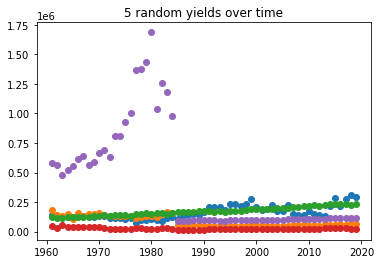

In [14]:
plt.figure()
plt.title("5 random yields over time")
for i in range(5):
    item_name = np.random.choice(crops_df['Item'].unique(), replace=False)
    item_yield_df = crops_df[(crops_df['Item'] == item_name) & (crops_df['Element'] == 'Yield')]
    item_yield_df_numeric = item_yield_df.drop(columns=non_year_cols)
    item_yield_means = item_yield_df_numeric.mean(axis='rows')
    plt.scatter(x=years, y=item_yield_means.to_numpy())
plt.show()

# Climate Data

In [15]:
## load datasets

# historic tempareture
temp_historic_path = os.path.join(climateuos_path, 'temperature', 'historical')
temp_historic_df = pd.concat([
    xr.open_dataset(os.path.join(temp_historic_path, filename)).to_dataframe().
        groupby(['lat', 'lon', pd.Grouper(level='time', freq='Y')]).mean() 
    for filename in os.listdir(temp_historic_path)
])

# ssp370 temperature
temp_ssp370_path = os.path.join(climateuos_path, 'temperature', 'ssp370')
temp_ssp370_df = pd.concat([
    xr.open_dataset(os.path.join(temp_ssp370_path, filename)).to_dataframe().
        groupby(['lat', 'lon', pd.Grouper(level='time', freq='Y')]).mean() 
    for filename in os.listdir(temp_ssp370_path)
])

# historic precipitation
prec_historic_path = os.path.join(climateuos_path, 'precipitation', 'historical')
prec_historic_df = pd.concat([
    xr.open_dataset(os.path.join(prec_historic_path, filename)).to_dataframe().
        groupby(['lat', 'lon', pd.Grouper(level='time', freq='Y')]).mean() 
    for filename in os.listdir(prec_historic_path)
])

# ssp370 precipitation
prec_ssp370_path = os.path.join(climateuos_path, 'precipitation', 'ssp370')
prec_ssp370_df = pd.concat([
    xr.open_dataset(os.path.join(prec_ssp370_path, filename)).to_dataframe().
        groupby(['lat', 'lon', pd.Grouper(level='time', freq='Y')]).mean() 
    for filename in os.listdir(prec_ssp370_path)
])

In [16]:
## re-format time index from TimeStamp to Period

# historic temperature
temp_historic_df.reset_index(inplace=True)
temp_historic_df['time'] = [pd.Period(ts.year) for ts in temp_historic_df['time']]
temp_historic_df.set_index(['lat', 'lon', 'time'], inplace=True)

# ssp370 temperature
temp_ssp370_df.reset_index(inplace=True)
temp_ssp370_df['time'] = [pd.Period(ts.year) for ts in temp_ssp370_df['time']]
temp_ssp370_df.set_index(['lat', 'lon', 'time'], inplace=True)

# historic precipitation
prec_historic_df.reset_index(inplace=True)
prec_historic_df['time'] = [pd.Period(ts.year) for ts in prec_historic_df['time']]
prec_historic_df.set_index(['lat', 'lon', 'time'], inplace=True)

# ssp370 precipitation
prec_ssp370_df.reset_index(inplace=True)
prec_ssp370_df['time'] = [pd.Period(ts.year) for ts in prec_ssp370_df['time']]
prec_ssp370_df.set_index(['lat', 'lon', 'time'], inplace=True)

In [17]:
## merge and write DFs

# write historic merged DFs
temp_historic_df.columns = ['tas']
temp_historic_df['pr'] = prec_historic_df['pr']
historic_df = temp_historic_df.copy().sort_index()
temp_historic_df = None
prec_historic_df = None
historic_df.to_pickle(os.path.join(climateuos_path, 'historic.pkl'))

# write ssp370 merged DFs
temp_ssp370_df.colums = ['tas']
temp_ssp370_df['pr'] = prec_ssp370_df['pr']
ssp370_df = temp_ssp370_df.copy().sort_index()
temp_ssp370_df = None
prec_ssp370_df = None
ssp370_df.to_pickle(os.path.join(climateuos_path, 'ssp370.pkl'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


# Upsampling

In [18]:
historic_df = pd.read_pickle(os.path.join(climateuos_path, 'historic.pkl'))
ssp370_df = pd.read_pickle(os.path.join(climateuos_path, 'ssp370.pkl'))

In [19]:
historic_df.reset_index().dtypes

lat           float64
lon           float64
time    period[A-DEC]
tas           float32
pr            float32
dtype: object

In [20]:
def get_world_map_as_array(df, year, attribute, resample_factor=None):
  world_map = df.loc[:,:, pd.Period(year)][attribute]
  world_array = world_map.fillna(0).to_numpy().reshape((36, 72))

  if resample_factor is not None:
    world_array = zoom(world_array, resample_factor, order=1)

  return world_array

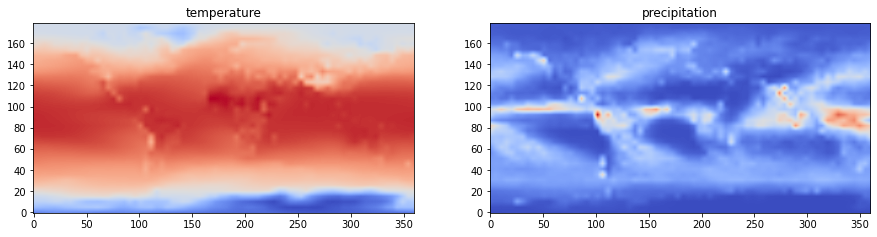

In [21]:
plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.title("temperature")
plt.imshow(get_world_map_as_array(historic_df, 1994, 'tas', 5), cmap='coolwarm', origin='lower')
plt.subplot(1, 2, 2)
plt.title("precipitation")
plt.imshow(get_world_map_as_array(historic_df, 1994, 'pr', 5), cmap='coolwarm', origin='lower')
plt.show()

In [22]:
def upsample_df(df):

    # create new indices
    years = df.reset_index()['time'].unique()
    latitude_idx = np.repeat(np.linspace(-89.75, 89.75, 360), 720 * years.size)
    # didn't get linspace to work here
    longitude_idx = np.repeat(np.tile([.25 + i * .5 for i in range(720)], 360), years.size)
    year_idx = np.repeat(years, 360 * 720)

    # initialize new DataFrame
    new_indices = pd.MultiIndex.from_arrays([latitude_idx, longitude_idx, year_idx], names=['lat', 'lon', 'time'])
    df_up = pd.DataFrame(index=new_indices, columns=['tas', 'pr']).sort_index()

    # initialize data maps (reverse indexing)
    temp_maps_up = np.empty((years.size, 360 * 720))
    prec_maps_up = np.empty((years.size, 360 * 720))

    # process data year by year
    for i, year in enumerate(years):
        print("Processing year", year, end=";")

        # upsample temperature map
        temp_map = df.loc[:,:,year]['tas'].fillna(method='bfill').to_numpy().reshape(36,72)
        temp_map_up = np.roll(pyramid_expand(temp_map, 10, sigma=1), 360, axis=1)

        # upsample precipitation map
        prec_map = df.loc[:,:,year]['pr'].fillna(method='bfill').to_numpy().reshape(36,72)
        prec_map_up = np.roll(pyramid_expand(prec_map, 10, sigma=1), 360, axis=1)

        # collect data maps
        temp_maps_up[i, :] = temp_map_up.reshape(-1)
        prec_maps_up[i, :] = prec_map_up.reshape(-1)

    print("")

    # assign data to new DataFrame
    df_up['tas'] = temp_maps_up.reshape(-1)
    df_up['pr'] = prec_maps_up.reshape(-1)

    print("Done!")

    return df_up.sort_index()

In [23]:
historic_df_up = upsample_df(historic_df)
historic_df_up.to_pickle(os.path.join(climateuos_path, 'historic_up.pkl'))

#ssp370_df_up = upsample_df(ssp370_df)
#ssp370_df_up.to_pickle(os.path.join(climateuos_path, 'ssp370_up.pkl'))

Processing year 1850;Processing year 1851;Processing year 1852;Processing year 1853;Processing year 1854;Processing year 1855;Processing year 1856;Processing year 1857;Processing year 1858;Processing year 1859;Processing year 1860;Processing year 1861;Processing year 1862;Processing year 1863;Processing year 1864;Processing year 1865;Processing year 1866;Processing year 1867;Processing year 1868;Processing year 1869;Processing year 1870;Processing year 1871;Processing year 1872;Processing year 1873;Processing year 1874;Processing year 1875;Processing year 1876;Processing year 1877;Processing year 1878;Processing year 1879;Processing year 1880;Processing year 1881;Processing year 1882;Processing year 1883;Processing year 1884;Processing year 1885;Processing year 1886;Processing year 1887;Processing year 1888;Processing year 1889;Processing year 1890;Processing year 1891;Processing year 1892;Processing year 1893;Processing year 1894;Processing year 1895;Processing year 1896;Processing ye

# Merge of climate and yield

In [24]:
# load climate data
historic_df_up = pd.read_pickle(os.path.join(climateuos_path, 'historic_up.pkl'))
#ssp370_df_up = pd.read_pickle(os.path.join(climateuos_path, 'ssp370_up.pkl'))

In [25]:
# load yield data
yield_ppd_path = os.path.join(input_path, 'Preprocessed')
yield_df = pd.read_pickle(os.path.join(yield_ppd_path, 'gdhy'))

In [26]:
# clean climate data for merge
historic_df_up.reset_index(inplace=True)
historic_df_up.drop(
    historic_df_up[
        (historic_df_up['lat'] < -89.75) 
        | (historic_df_up['lat'] > 89.75)
        | (historic_df_up['lon'] < .25)
        | (historic_df_up['lon'] > 359.75)
        | (historic_df_up['time'] < pd.Period(1981))
    ].index, 
    inplace=True
)

historic_df_up['lat'] = np.around(historic_df_up['lat'], decimals=2)
historic_df_up['lon'] = np.around(historic_df_up['lon'], decimals=2)

historic_df_up.rename(columns={'time': 'year'}, inplace=True)

historic_df_up.set_index(['lat', 'lon', 'year'], inplace=True)

In [27]:
# clean yield data for merge
yield_df.reset_index(inplace=True)
yield_df.drop(yield_df[yield_df['year'] > pd.Period(2014)].index, inplace=True)
yield_df.set_index(['lat', 'lon', 'year'], inplace=True)

In [28]:
# merge
final_df = yield_df.copy()
final_df['tas'] = historic_df_up['tas'].to_numpy()
final_df['pr'] = historic_df_up['pr'].to_numpy()
final_df.sort_index(inplace=True)
#final_df.drop(columns=['index'], inplace=True)

# write
final_df.to_pickle(os.path.join(input_path, 'merged_data.pkl'))

In [29]:
final_df.loc[52.25, 9.25, pd.Period(1994)]

maize                  NaN
maize_major            NaN
maize_second           NaN
rice                   NaN
rice_major             NaN
rice_second            NaN
soybean                NaN
wheat             6.926459
wheat_spring           NaN
wheat_winter      6.926459
tas             281.416575
pr                0.000028
Name: (52.25, 9.25, 1994), dtype: float64

In [30]:
final_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
maize,492983.0,3.616922,3.669226,0.000000e+00,1.022986,2.279913,4.969772,31.281275
maize_major,492227.0,3.622025,3.670636,0.000000e+00,1.027217,2.288308,4.975966,31.281275
maize_second,98346.0,1.774801,1.269645,0.000000e+00,0.907112,1.369119,2.312555,8.563225
rice,313283.0,4.197598,3.476354,0.000000e+00,1.659047,3.214644,5.802727,25.617229
rice_major,312693.0,4.156510,3.401337,0.000000e+00,1.728501,3.226489,5.678993,25.617229
rice_second,52515.0,4.868374,4.170830,0.000000e+00,1.098424,3.887612,7.954103,20.429527
soybean,202052.0,2.099919,1.091102,0.000000e+00,1.303313,2.036736,2.806466,10.800001
wheat,412743.0,3.493071,3.222768,0.000000e+00,1.032999,2.549743,5.042047,18.792427
wheat_spring,166215.0,3.764681,3.806995,0.000000e+00,0.965352,2.527432,5.119692,18.792427
wheat_winter,280821.0,3.313036,2.815353,0.000000e+00,1.107345,2.558235,4.845385,17.268173


In [31]:
final_df

maize  maize_major  ...         tas            pr
lat    lon    year                      ...                          
-89.75 0.25   1981    NaN          NaN  ...  231.770077  8.480935e-07
              1982    NaN          NaN  ...  230.616391  5.427699e-07
              1983    NaN          NaN  ...  230.544235  3.593537e-07
              1984    NaN          NaN  ...  231.361722  7.748000e-07
              1985    NaN          NaN  ...  229.807076  4.490396e-07
...                   ...          ...  ...         ...           ...
 89.75 359.75 2010    NaN          NaN  ...  260.886236  5.656227e-06
              2011    NaN          NaN  ...  260.739026  6.271095e-06
              2012    NaN          NaN  ...  260.295706  6.286944e-06
              2013    NaN          NaN  ...  260.172720  6.037444e-06
              2014    NaN          NaN  ...  260.620195  5.194389e-06

[8812800 rows x 12 columns]

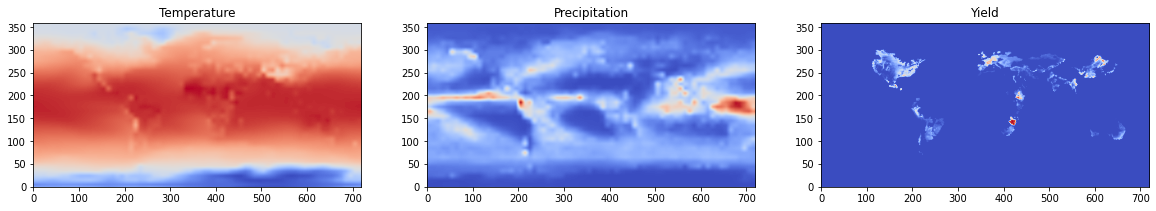

In [36]:
temp_map = np.roll(final_df.loc[:,:,pd.Period(2000)]['tas'].to_numpy().reshape(360,720), 360, axis=1)
prec_map = np.roll(final_df.loc[:,:,pd.Period(2000)]['pr'].to_numpy().reshape(360,720), 360, axis=1)
yield_map = np.roll(final_df.loc[:, :, pd.Period(2000)]['wheat'].fillna(0).to_numpy().reshape(360,720), 360, axis=1)
plt.figure(figsize=(20,30))
plt.subplot(1, 3, 1)
plt.title("Temperature")
plt.imshow(temp_map, cmap='coolwarm', origin='lower')
plt.subplot(1, 3, 2)
plt.title("Precipitation")
plt.imshow(prec_map, cmap='coolwarm', origin='lower')
plt.subplot(1, 3, 3)
plt.title("Yield")
plt.imshow(yield_map, cmap='coolwarm', origin='lower')
plt.show()